In [1]:
import numpy as np
import pandas as pd
import json
import os

In [4]:
files = [os.path.join("tables", item) for item in os.listdir("tables") if not item.endswith("rms_metrics.json")]
table_headings = [
    "variable",
    "units",
    "base-no-ML",
    "base-fast-sat-adj-no-ML",
    "Tq-RF",
    "TqR-RF",
    "TquvR-RF",
    "TquvR-NN",
    "TqR-NN"
]

ablation_data = []
for file in files:
    with open(file, "r") as f:
        data = json.load(f)
    if isinstance(data, dict):
        data = [data]
    for entry in data:
        variable_data = []
        for column in table_headings:
            variable_data.append(entry[column])
        ablation_data.append(variable_data)

In [5]:
df = pd.DataFrame(ablation_data, columns=table_headings)
df

,variable,units,base-no-ML,base-fast-sat-adj-no-ML,Tq-RF,TqR-RF,TquvR-RF,TquvR-NN,TqR-NN
0,TMP200_rmse,K,3.436004,3.463906,3.161889,3.064295,5.085435,3.876489,3.066255
1,land_surface_precipitation_bias,mm/day,1.093459,-0.328261,0.796128,0.115097,0.359086,0.002964,0.036406
2,global_surface_precipitation_rmse,mm/day,3.655571,3.061411,2.659678,2.538595,2.568616,2.527530,2.556271


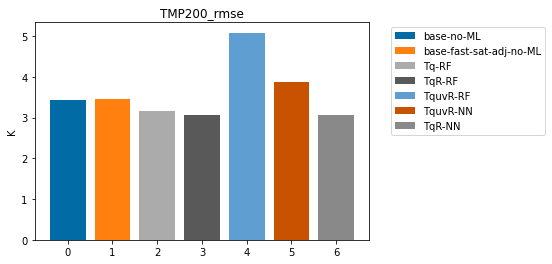

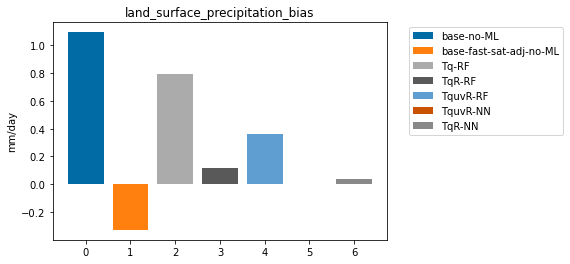

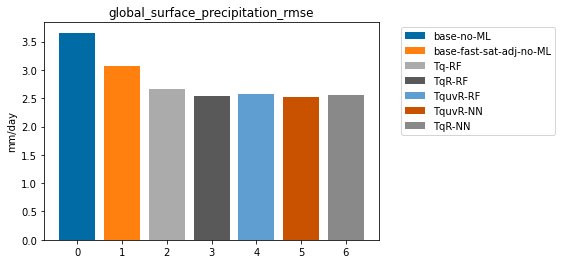

In [6]:
import matplotlib.pyplot as plt

for variable in df["variable"].values:
    if variable.endswith("std"):
        continue

    row = df.loc[ df["variable"] == variable].values[0]
    y = row[2:]
    title = row[0]
    labels = df.columns[2:].values
    units = row[1]

    if variable.endswith("mean"):
        for i in range(len(y)):
            std = df.loc[ df["variable"] == variable.replace("mean", "std")].values[0][2:]
            plt.bar([i,], [y[i],] , yerr=std[i], label=labels[i])

    else:
        for i in range(len(y)):
            plt.bar([i,], [y[i],], label=labels[i])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.ylabel(units)
    #plt.xaxis().set_visible(False)
    plt.title(title)
    plt.show()

#### Can copy/paste this output into the latex document.

In [7]:
row_names = {
    "h500_rms_global_day3-7_ic_mean": "Z500 RMSE 3-7d fcst",
    "tmp850_rms_global_day3-7_ic_mean": "T850 RMSE 3-7d fcst",
    "global_surface_precipitation_rmse": "Prec RMSE time-mean",
    "land_surface_precipitation_bias": "Prec bias land-time-mean",
    "TMP200_rmse": "T200 RMSE time-mean"
}

print_table_data = []
for variable in df.variable:
    entry = df[df.variable==variable]
    if "ic_std" not in variable:
        variable_data = []
        for heading in table_headings:
            item = entry[heading].item()
            if isinstance(item, float):
                variable_data.append(" {:.1f}".format(item))
            else:
                variable_data.append(item)
    else:
        for i, heading in enumerate(table_headings):
            item = entry[heading].item()
            if isinstance(item, float):
                variable_data[i] = (
                    variable_data[i] 
                    + " ({:.1f})".format(item)
                )
    if "ic_mean" not in variable:
        print_table_data.append(variable_data)
table_df = pd.DataFrame(print_table_data, columns=table_headings)
table_df

,variable,units,base-no-ML,base-fast-sat-adj-no-ML,Tq-RF,TqR-RF,TquvR-RF,TquvR-NN,TqR-NN
0,TMP200_rmse,K,3.4,3.5,3.2,3.1,5.1,3.9,3.1
1,land_surface_precipitation_bias,mm/day,1.1,-0.3,0.8,0.1,0.4,0.0,0.0
2,global_surface_precipitation_rmse,mm/day,3.7,3.1,2.7,2.5,2.6,2.5,2.6


In [8]:

print(
    table_df[table_df.variable.isin(row_names.keys())].replace(row_names).to_latex(
        index=False, 
    )
)

\begin{tabular}{lllllllll}
\toprule
                 variable &   units & base-no-ML & base-fast-sat-adj-no-ML & Tq-RF & TqR-RF & TquvR-RF & TquvR-NN & TqR-NN \\
\midrule
      T200 RMSE time-mean &       K &        3.4 &                     3.5 &   3.2 &    3.1 &      5.1 &      3.9 &    3.1 \\
 Prec bias land-time-mean &  mm/day &        1.1 &                    -0.3 &   0.8 &    0.1 &      0.4 &      0.0 &    0.0 \\
      Prec RMSE time-mean &  mm/day &        3.7 &                     3.1 &   2.7 &    2.5 &      2.6 &      2.5 &    2.6 \\
\bottomrule
\end{tabular}



#### effect of wind tendencies (compare 2-3) on the upper atmosphere air temperature bias

In [ ]:
import fsspec
import xarray as xr

def plot_zonal_pressure_bias(diags, diags_baseline, var, **plot_kwargs):
    fig = plt.figure()
    ds = xr.concat(
        [diags_baseline[[var]]] + [diags[experiment][[var]] for experiment in diags] ,
        dim=pd.Index(["baseline"] + [f"{tau} hr" for tau in diags.keys()], name="timescale")
    )

    return ds[var].plot(
        x="latitude",
        yincrease=False,
        col="timescale",
        **plot_kwargs
    )
    return fig

In [ ]:
experiments = [
    "temperature-moisture-RF",
    "temperature-moisture-winds-RF",
    "temperature-moisture-winds-prescribed-sfc-RF",
    "temperature-moisture-winds-prescribed-sfc-NN-ensemble"
]

prog_run_paths = [
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-dq1-dq2-rf/initial_conditions_runs/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/control-rf/prognostic_run_tendencies_only_ics/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/rf/initial_conditions_runs/20160805.000000",
    "gs://vcm-ml-experiments/2021-05-11-nudge-to-c3072-corrected-winds/nn-ensemble-model/initial_conditions_runs_rectified_nn_rad/20160805.000000"
]
paths = [f"gs://vcm-ml-public/argo/prog-report-nudge-to-3km-ablation-runs/{exp}" for exp in experiments]


with fsspec.open("gs://vcm-ml-public/argo/2021-05-04-nudge-to-c3072-prog-timescales/physics-on-baseline/diags.nc", "rb") as f:
    diags_baseline = xr.open_dataset(f).load()
    
    
diags = {}
for experiment, path in zip(experiments , paths):
    print(path)
    with fsspec.open(f"{path}/diags.nc", "rb") as f:
        diags[experiment] = xr.open_dataset(f).load()

In [ ]:
fig = plot_zonal_pressure_bias(diags, diags_baseline, "air_temperature_pressure_level_zonal_bias", vmax=30)
fig.cbar.set_label("air temperature bias [K]")

# plot function puts baseline first
labels = [
    "baseline",
    "temperature-moisture \n RF",
    "temperature-moisture-winds \n RF",
    "temperature-moisture-winds \n prescribed-sfc \n RF",
    "temperature-moisture-winds \n prescribed-sfc \n NN-ensemble"
]
for ax, label in zip(fig.axes[0], labels):
    ax.set_xlabel("Latitude [deg]")
    ax.set_title(label)
fig.axes[0][0].set_ylabel("Pressure [Pa]")